# Building Simple Models

#### Ross Willett

In this file, several models will be built using the vectorized text data and additional numerical columns. The performance of these models will be evaluated and the hyperparameters optimized to find the best model of these simple models.

## Initial Formatting

In order to prevent any data leakage into the analysis, the data must be first split into a train, validation and test set.

In [184]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import regex library
import re

# Import math library
import math

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import natural language processing libraries
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV

# Import processing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Import modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB

# Import model Evaluation Libraries
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import Dimensionality Reduction libraries
from sklearn.decomposition import PCA

# Import pipeline library
from sklearn.pipeline import Pipeline

# Import temporary file creation library
from tempfile import mkdtemp

In [92]:
# Import warnings and supress them
import warnings
warnings.filterwarnings('ignore')

In [195]:
# Configure Pandas to show all columns / rows
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000
# Set column max width larger
pd.set_option('display.max_colwidth', 500)

In [94]:
# Set up matplotlib to use nice styles
plt.style.use('ggplot')

In [95]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rosswillett/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [96]:
def custom_tokenizer(text):
    '''
    Accepts a string and returns a list of stemmed words filtered of english stop words
    
    Parameters
    ----------
    text: A string which contains words to be stemmed and filtered of stop words
    
    Returns
    ----------
    Ret: An array of strings containing the stemmed and filtered words
    
    Example
    ----------
    >>>> custom_tokenizer('Going to the park for a run!')
    ['go','park', 'run']
    '''
    # allow alphabetical characters and spaces only
    processed_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Filter out additional spaces
    processed_text = re.sub(r'\s\s*', ' ', processed_text)
    # Split sentence into words
    listofwords = processed_text.split(' ')
    # Initialize the list to store the stemmed words in
    listofstemmed_words = []
    # Iterate over each word in the content
    for word in listofwords:
        # Remove stopwords and any tokens that are just empty strings
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem the word
            stemmed_word = stemmer.stem(word)
            # Add the stemmed word to the list of words
            listofstemmed_words.append(stemmed_word)
    # Returned the stemmed list of words
    return listofstemmed_words

In [97]:
# Load data from phishing email csv
email_df = pd.read_csv('./data/fraud_all_data_clean_4.csv')

In [98]:
# Examining the shape of the fraud data
email_df.shape

(12401, 6)

In [99]:
# Looks at the split between fraud and non-fraud emails in the data
email_df['fraud'].value_counts()

0    6743
1    5658
Name: fraud, dtype: int64

In [100]:
# Set the feature and target data frames
X = email_df.drop(columns=['fraud'])
y = email_df.loc[:, ['fraud']]

In [101]:
# Split the data frames into test and remainder data
X_remainder, X_test, y_remainder, y_test = train_test_split(
    X,
    y,
    stratify=y,
    random_state=1337,
    test_size=0.2,
)
# Reset the indexes of the resulting data frames so the counts return to 1 to n
X_remainder.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_remainder.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [102]:
# Split the data frames into train and validation data
X_train, X_validation, y_train, y_validation = train_test_split(
    X_remainder,
    y_remainder,
    stratify=y_remainder,
    random_state=1337,
    test_size=0.2,
)
# Reset the indexes of the resulting data frames so the counts return to 1 to n
X_train.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_validation.reset_index(drop=True, inplace=True)

Now that the data has been split into train, validation and test data, the count vectorizer can be fit on the train data and used to transform the other data sets. The vectorizer will be set to use the custom tokenizer which will remove stop words and stem each word. This vectorizer will also require a minimum frequency of 5% for any word to be used in the vectorizer. This will reduce any over-fitting for any models trained on the data set.

In [103]:
# Initialize a column transformer to be used to vectorize the text content and pass through the other columns
cv_transf = ColumnTransformer([
        (
            # Set the name of the transformer
            'count_vectorizer',
            # Intantiate the count vectorizer
            CountVectorizer(
                # Set the tokenizer for the vectorizer to the custom tokenizer
                tokenizer=custom_tokenizer,
                # Set a minimum requirement of 5% frequency for words to be used for vectorizer
                min_df=0.05
            ),
            # Set the target column of the count vectorizer
            'content',
        )
    ],
    # Specify that all other columns for the data frame should be left as-is
    remainder='passthrough'
)

In [104]:
# Fit and transform the data for the training data set
X_train_vec = cv_transf.fit_transform(X_train)

In [105]:
# Create a data frame from the vectorized data
X_train_vec = pd.DataFrame(
    data=X_train_vec.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Look at the top 10 entries in the data frame
X_train_vec.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [106]:
# Look at the resulting shape of the data frame
X_train_vec.shape

(7936, 283)

In [107]:
# Using the fitted vectorizer transform the validation data set
X_validation_vec = cv_transf.transform(X_validation)
# Turn the transformed validation data into a data frame
X_validation_vec = pd.DataFrame(
    data=X_validation_vec.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Look at the top 10 entries of the data frame
X_validation_vec.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [108]:
X_validation_vec.shape

(1984, 283)

### PCA Comparison

In [109]:
pca = PCA(n_components=4)

In [110]:
X_pca = pca.fit_transform(X_train_vec)

<Figure size 1500x1000 with 0 Axes>

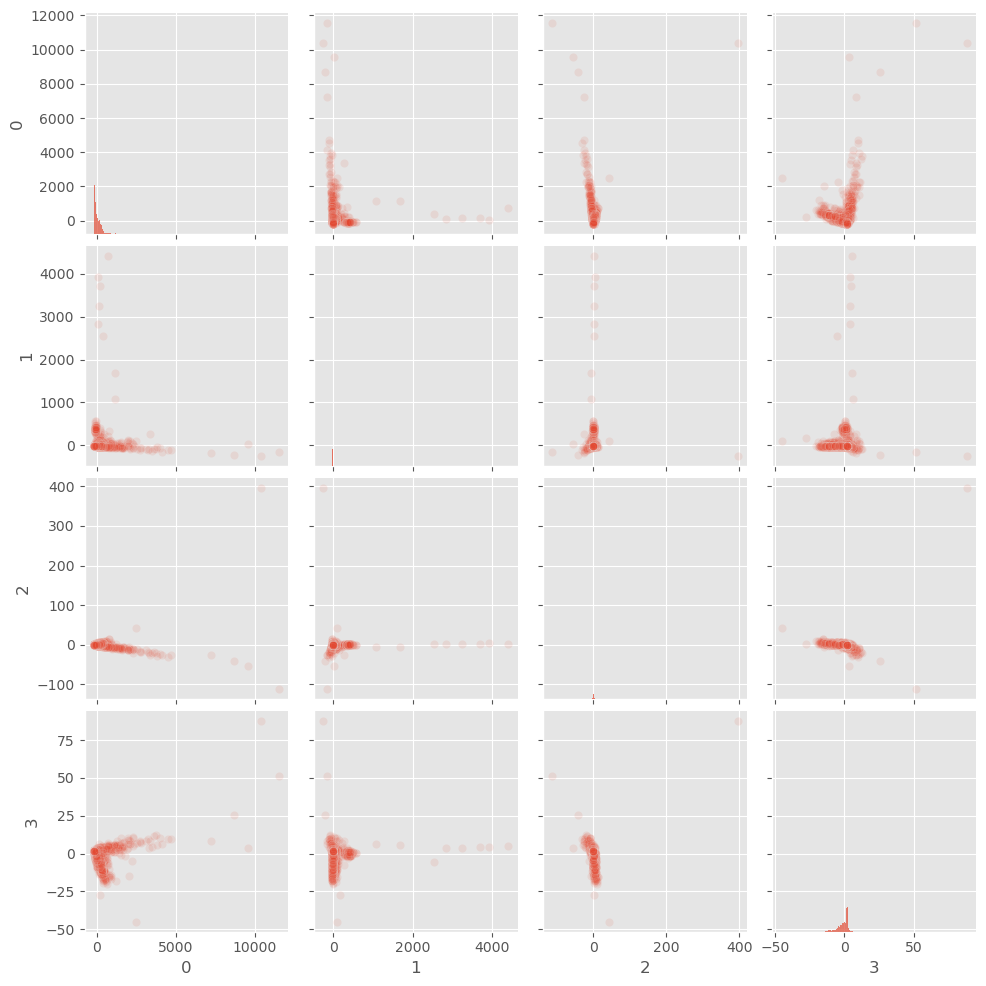

In [111]:
plt.figure(figsize=(15,10))
sns.pairplot(pd.DataFrame(X_pca), kind='scatter', plot_kws={'alpha':0.1})
plt.show()

## Model Building

Now that the data has been appropriately vectorized, models can now be trained on it. For initial analysis, the logistic regression, KNN, decision tree and naive bayes models will be fitted and tested.

In [112]:
# Instantiate a dictionary to record the results of the initial models
results_dict = {
    'Model': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
}

### Logistic Regression Model

The first model that will be tested is the logistic regression model.

In [113]:
# Instantiate the logistic regression model
log_reg_model = LogisticRegression()
# Fit the logistic regression model to the training data
log_reg_model.fit(X_train_vec, y_train)
# Get the % accuracy of the logistic regression model
log_reg_train_acc = log_reg_model.score(X_train_vec, y_train) * 100
# Print the logistic regression accuracy
print(log_reg_train_acc)

97.20262096774194


In [114]:
# Get the % accuracy of the logistic regression model on the validation data
log_reg_val_acc = log_reg_model.score(X_validation_vec, y_validation) * 100
print(log_reg_val_acc)

96.92540322580645


In [115]:
# Add the results of the logistic regression model to the results dictionary
results_dict['Model'].append('Logistic Regression')
results_dict['Train Accuracy'].append(log_reg_train_acc)
results_dict['Validation Accuracy'].append(log_reg_val_acc)

This 97% accuracy result seems to be very high, especially without any parameter optimization. Given this, the coefficients the model has applied to the columns will be examined.

In [116]:
# Create a data frame from the coefficients of the logistic regression model labelled by column
log_reg_coef_pd = pd.DataFrame(log_reg_model.coef_, columns=X_train_vec.columns, index=['Coefficient']).T

In [117]:
# Sort the coefficients in descending order and take the top 10 values
log_reg_coef_pd.sort_values(by='Coefficient', ascending=False).head(10)

,Coefficient
count_vectorizer__bank,2.138286
count_vectorizer__yahoo,1.916926
count_vectorizer__account,1.879155
count_vectorizer__transact,1.791473
count_vectorizer__money,1.733199
count_vectorizer__dear,1.722245
count_vectorizer__god,1.532576
count_vectorizer__fund,1.345040
count_vectorizer__pleas,1.241014
count_vectorizer__name,1.239202


As demonstrated by the top 10 coefficients, there are several words which the logistic regression model has associated with a positive fraud result. These words seem to strongly relate to the top 10 words by count that appeared in the fraud data set. It stands to reason that these values have large positive coefficients, however, there appears to be several words that have high coefficients such as 'yahoo' which may indicate some bias or consistency in the underlying data.

In [118]:
# Sort the coefficients in ascending order and take the top 10 values
log_reg_coef_pd.sort_values(by='Coefficient', ascending=True).head(10)

,Coefficient
count_vectorizer__state,-1.900655
count_vectorizer__call,-1.034994
count_vectorizer__mailman,-1.017628
count_vectorizer__meet,-0.970735
count_vectorizer__said,-0.968500
count_vectorizer__see,-0.965987
count_vectorizer__like,-0.960457
count_vectorizer__follow,-0.958958
count_vectorizer__releas,-0.931082
count_vectorizer__group,-0.874493


Similar to the top 10 coefficients, the bottom 10 coefficients appeared with a relatively high frequency in the top ham words. This stands to reason, but as stated before the prevalence of a words like 'state' and 'mailman' could indicate some bias in the underlying data.

### KNN Model

The next model that will be evaluated is a KNN model with cosine similarity. The reason cosine similarity will be used for this model is due to the fact that the proportional counts of certain words is likely more important than the cartesian size of the vector. Given this, a cosine similarity will likely place vectors of similar proportions closer together despite difference in magnitudes.

In [119]:
# Initialize scaler
minMaxScaler = MinMaxScaler()
# Fit the scaler on the train data
minMaxScaler.fit(X_train_vec)
# Transform the train data
x_mm_scaled_vec = minMaxScaler.transform(X_train_vec)
# Instantiate and fit the KNN model with cosine similarity
knn_model = KNeighborsClassifier(metric='cosine')
knn_model.fit(x_mm_scaled_vec, y_train)
# Get the train % accuracy and print it
knn_train_acc = knn_model.score(x_mm_scaled_vec, y_train) * 100
print(knn_train_acc)

96.01814516129032


In [120]:
# Scale the validation data set using the fitted scaler
x_val_scaled_vec = minMaxScaler.transform(X_validation_vec)
knn_val_acc = knn_model.score(x_val_scaled_vec, y_validation) * 100
print(knn_val_acc)

94.75806451612904


In [121]:
# Append the results of the KNN model to the results dictionary
results_dict['Model'].append('KNN (Cosine Similarity)')
results_dict['Train Accuracy'].append(knn_train_acc)
results_dict['Validation Accuracy'].append(knn_val_acc)

The KNN accuracy of 96% for train and 95% for validation seems quite high, however it is not quite as high as the accuracy of the logistic regression model.

### Decision Tree Model

Next the decision tree model will be created and evaluated.

In [122]:
# Instantiate the Decision Tree Classifier
dec_tree_model = DecisionTreeClassifier()
# Fit the model on the training data
dec_tree_model.fit(X_train_vec, y_train)
# Get the % accuracy of the decision tree model on the train data
dt_train_acc = dec_tree_model.score(X_train_vec, y_train) * 100
print(dt_train_acc)

99.92439516129032


In [123]:
# Get the % accuracy of the decision tree model on the validation data
dt_val_acc = dec_tree_model.score(X_validation_vec, y_validation) * 100
print(dt_val_acc)

93.75


In [124]:
# Append the results of the decision tree model to the results dictionary
results_dict['Model'].append('Decision Tree')
results_dict['Train Accuracy'].append(dt_train_acc)
results_dict['Validation Accuracy'].append(dt_val_acc)

The accuracy of the decision tree model is very high for the training data set at 99% but the validation accuracy is significantly lower at 94%. This is likely the result of overfitting on the training data which results in worse validation accuracy than the other two models. 

### Naive Bayes Model

The last model will be fitted and evaluated is the naive bayes model. For this purpose, the Bournoulli Naive Bayes model will be used since the result is a binary categorization.

In [125]:
# Instantiate the model
nb_model = BernoulliNB()
# Train the model
nb_model.fit(X_train_vec, y_train)
# Get the model % accuracy of the model on the train data set
nb_train_acc = nb_model.score(X_train_vec, y_train) * 100
print(nb_train_acc)

89.33971774193549


In [126]:
# Get the model % accuracy on the validation data set
nb_test_acc = nb_model.score(X_validation_vec, y_validation) * 100
print(nb_test_acc)

88.91129032258065


In [127]:
# Append the results to the results dictionary
results_dict['Model'].append('Naive Bayes')
results_dict['Train Accuracy'].append(nb_train_acc)
results_dict['Validation Accuracy'].append(nb_test_acc)

The unoptimized results from the Naive Bayes model appear to be disappointing compared to the other models with a train accuracy of 89% and a test accuracy of 89% as well. That said, further optimization may improve the performance of this model.

### Comparing The Model Results

The models' accuracy results will be represented graphically and through a table to have a better visual comparison of the results.

In [128]:
# Create a data frame from the results dictionary
results_df = pd.DataFrame(results_dict)

In [129]:
# View the results data frame
results_df

,Model,Train Accuracy,Validation Accuracy
0,Logistic Regression,97.202621,96.925403
1,KNN (Cosine Similarity),96.018145,94.758065
2,Decision Tree,99.924395,93.750000
3,Naive Bayes,89.339718,88.911290


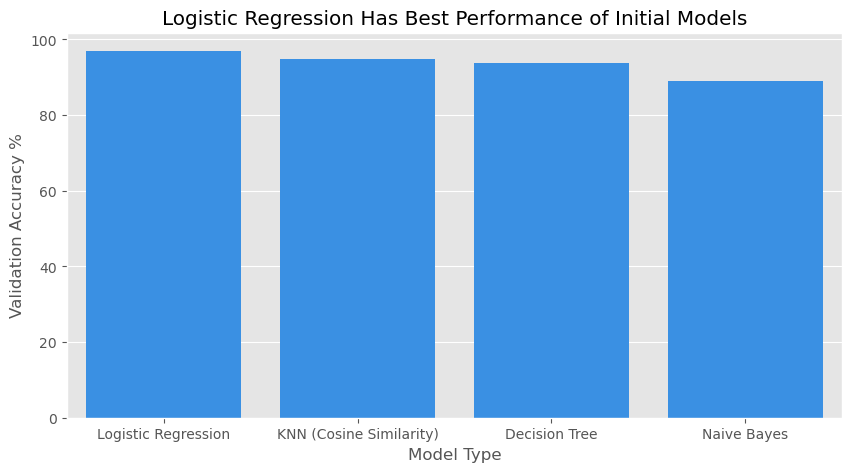

In [130]:
# Initialize the chart
plt.figure(figsize=(10,5))
# Create a bar plot from the validation accuracies in the results data frame
mod_perf_fig = sns.barplot(
    x='Model',
    y='Validation Accuracy',
    data=results_df.sort_values('Validation Accuracy', ascending=False),
    color='dodgerblue'
)
# Add a title and labels
plt.title('Logistic Regression Has Best Performance of Initial Models')
plt.xlabel('Model Type')
plt.ylabel('Validation Accuracy %')
# Display the chart
plt.show()

As demonstrated by the results table and chart, of the four models with no hyper-parameter optimization, the Logistic regression model performs best with a validation accuracy of 97%.

In [131]:
# Save the chart
mod_perf_fig.figure.savefig('model_perf', bbox_inches="tight")

### TFIDF Vectorizer

The previous models had been trained and evaluated on data transformed by a count vectorizer. Since the count vectorizer does not take term frequency into account, it is possible that some words may be weighted too heavily especially if they are repeated multiple times in a single document. As such, the data will be transformed using a TFIDF vectorizer and the same simple models trained and evaluated using the data vectorized by the TFIDF vectorizer. In order to do this, the text content will need to be transformed using this TFIDF vectorizer.

In [132]:
# Instantiate column transformer with TFIDF vectorizer
tfidf_transf = ColumnTransformer([
        (
            # Name the transformation
            'tfidf_vectorizer',
            # Instantate the TFIDF vectorizer with the custom tokenizer and a minimum term frequency of 5%
            TfidfVectorizer(
                tokenizer=custom_tokenizer,
                min_df=0.05
            ),
            # Select the column to be transformed
            'content',
        )
    ],
    # Specify that all other columns should remain unchanged
    remainder='passthrough'
)

In [133]:
# Fit and transform the x training data with the TFIDF vectorizer
X_train_tfidf = tfidf_transf.fit_transform(X_train)

In [134]:
# Put the transformed x training data into a data frame
X_train_tfidf = pd.DataFrame(
    data=X_train_tfidf.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Check the top 10 columns of the data frame
X_train_tfidf.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [135]:
# Check the shape of the data
X_train_tfidf.shape

(7936, 283)

In [136]:
# Transform the validation data using the fitted TFIDF vectorizer
X_validation_tfidf = cv_transf.transform(X_validation)
# Put the validation data into a data frame
X_validation_tfidf = pd.DataFrame(
    data=X_validation_tfidf.toarray(),
    columns=cv_transf.get_feature_names_out(),
)
# Look at the top 10 columns from the validation data frame
X_validation_tfidf.head(10)

,count_vectorizer__abl,count_vectorizer__accept,count_vectorizer__access,count_vectorizer__accord,count_vectorizer__account,count_vectorizer__actual,count_vectorizer__address,count_vectorizer__agre,count_vectorizer__agreement,count_vectorizer__along,count_vectorizer__also,count_vectorizer__amount,count_vectorizer__anoth,count_vectorizer__arrang,count_vectorizer__ask,count_vectorizer__assist,count_vectorizer__assur,count_vectorizer__attent,count_vectorizer__back,count_vectorizer__bank,count_vectorizer__base,count_vectorizer__behalf,count_vectorizer__believ,count_vectorizer__beneficiari,count_vectorizer__best,count_vectorizer__bless,count_vectorizer__busi,count_vectorizer__call,count_vectorizer__care,count_vectorizer__case,count_vectorizer__chang,count_vectorizer__choos,count_vectorizer__claim,count_vectorizer__click,count_vectorizer__client,count_vectorizer__close,count_vectorizer__come,count_vectorizer__commun,count_vectorizer__compani,count_vectorizer__complet,count_vectorizer__concern,count_vectorizer__confid,count_vectorizer__confidenti,count_vectorizer__confirm,count_vectorizer__contact,count_vectorizer__corpor,count_vectorizer__could,count_vectorizer__countri,count_vectorizer__cours,count_vectorizer__current,count_vectorizer__custom,count_vectorizer__day,count_vectorizer__deal,count_vectorizer__dear,count_vectorizer__death,count_vectorizer__deceas,count_vectorizer__decid,count_vectorizer__depart,count_vectorizer__deposit,count_vectorizer__develop,count_vectorizer__direct,count_vectorizer__discov,count_vectorizer__discuss,count_vectorizer__done,count_vectorizer__due,count_vectorizer__easi,count_vectorizer__enabl,count_vectorizer__end,count_vectorizer__even,count_vectorizer__everi,count_vectorizer__execut,count_vectorizer__fact,count_vectorizer__faith,count_vectorizer__famili,count_vectorizer__father,count_vectorizer__file,count_vectorizer__final,count_vectorizer__financi,count_vectorizer__find,count_vectorizer__first,count_vectorizer__five,count_vectorizer__follow,count_vectorizer__foreign,count_vectorizer__form,count_vectorizer__former,count_vectorizer__forward,count_vectorizer__free,count_vectorizer__friend,count_vectorizer__full,count_vectorizer__fund,count_vectorizer__futur,count_vectorizer__gener,count_vectorizer__get,count_vectorizer__give,count_vectorizer__given,count_vectorizer__go,count_vectorizer__god,count_vectorizer__good,count_vectorizer__got,count_vectorizer__govern,count_vectorizer__great,count_vectorizer__group,count_vectorizer__hear,count_vectorizer__help,count_vectorizer__henc,count_vectorizer__home,count_vectorizer__hope,count_vectorizer__hous,count_vectorizer__howev,count_vectorizer__hundr,count_vectorizer__id,count_vectorizer__immedi,count_vectorizer__import,count_vectorizer__includ,count_vectorizer__inform,count_vectorizer__interest,count_vectorizer__intern,count_vectorizer__invest,count_vectorizer__involv,count_vectorizer__issu,count_vectorizer__keep,count_vectorizer__kin,count_vectorizer__know,count_vectorizer__last,count_vectorizer__late,count_vectorizer__law,count_vectorizer__leav,count_vectorizer__left,count_vectorizer__legal,count_vectorizer__let,count_vectorizer__letter,count_vectorizer__life,count_vectorizer__like,count_vectorizer__link,count_vectorizer__list,count_vectorizer__live,count_vectorizer__long,count_vectorizer__look,count_vectorizer__made,count_vectorizer__mail,count_vectorizer__mailman,count_vectorizer__make,count_vectorizer__manag,count_vectorizer__mani,count_vectorizer__matter,count_vectorizer__may,count_vectorizer__meet,count_vectorizer__member,count_vectorizer__messag,count_vectorizer__might,count_vectorizer__million,count_vectorizer__money,count_vectorizer__move,count_vectorizer__much,count_vectorizer__must,count_vectorizer__name,count_vectorizer__nation,count_vectorizer__necessari,count_vectorizer__need,count_vectorizer__net,count_vectorizer__never,count_vectorizer__new,count_vectorizer__next,count_vectorizer__note,count_vectorizer__number,count_vectorizer__offer,count_vector

In [137]:
# Check the shape of the validation data
X_validation_tfidf.shape

(1984, 283)

### TFIDF Logistic Regression

Now that the training and validation data has been transformed with the TFIDF vectorize, the simple models can be fit and evaluated using this data.

In [138]:
# Initialize TFIDF results dictionary
tfidf_results_dict = {
    'Model': [],
    'Train Accuracy': [],
    'Validation Accuracy': [],
}

In [139]:
# Instantiate the logistic regression model
log_reg_model_tfidf = LogisticRegression()
# Fit the logistic regression model
log_reg_model_tfidf.fit(X_train_tfidf, y_train)
# Display the train accuracy of the logistic regression model
train_acc_log_tfidf = log_reg_model_tfidf.score(X_train_tfidf, y_train) * 100
print(train_acc_log_tfidf)

96.24495967741935


In [140]:
# Display the validation accuracy of the logistic regression model
val_acc_log_tfidf = log_reg_model_tfidf.score(X_validation_tfidf, y_validation) * 100
print(val_acc_log_tfidf)

91.48185483870968


In [141]:
# Append the results to the results dictionary
tfidf_results_dict['Model'].append('Logistic Regression')
tfidf_results_dict['Train Accuracy'].append(train_acc_log_tfidf)
tfidf_results_dict['Validation Accuracy'].append(val_acc_log_tfidf)

At first glance, it seems the accuracy of a default logistic regression using the TFIDF vectorized features is lower on both the train and validation scores than the logistic regression trained on the count vectorized features. Looking at the coefficients may clarify as to why this is happening.

In [142]:
# Create a data frame containing the coefficient values for the log reg trained on TFIDF
log_reg_coef_tfidf_pd = pd.DataFrame(log_reg_model_tfidf.coef_, columns=X_train_vec.columns, index=['Coefficient']).T

In [143]:
# Show the top 10 highest coefficients for the log reg model
log_reg_coef_tfidf_pd.sort_values(by='Coefficient', ascending=False).head(10)

,Coefficient
count_vectorizer__account,7.745774
count_vectorizer__bank,5.736816
count_vectorizer__money,4.555428
count_vectorizer__fund,4.103262
count_vectorizer__pleas,3.587422
count_vectorizer__transact,3.161393
count_vectorizer__busi,2.845029
count_vectorizer__us,2.769049
count_vectorizer__transfer,2.657558
count_vectorizer__dear,2.510981


It appears that the coefficients for the model trained on TFIDF data resulted in much higher values than the model trained on count vectorized data. This is likely due to the fact that the word vectors resulting from TFIDF tend to have lower values. However, this does indicate that the use of specific words in the text content will be likely to result in a positive fraud result.

### TFIDF KNN

Next the result of KNN with TFIDF vectorized content will be evaluated.

In [144]:
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(X_train_tfidf)
x_mm_scaled_tfidf = minMaxScaler.transform(X_train_tfidf)
knn_model_tfidf = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model_tfidf.fit(x_mm_scaled_tfidf, y_train)
knn_tfidf_train_acc = knn_model_tfidf.score(x_mm_scaled_tfidf, y_train) * 100
print(knn_tfidf_train_acc)

97.60584677419355


In [145]:
x_mm_scaled_tfidf = minMaxScaler.transform(X_validation_vec)
knn_tfidf_val_acc = knn_model.score(x_mm_scaled_tfidf, y_validation) * 100
print(knn_tfidf_val_acc)

95.16129032258065


In [146]:
# Append the results of the KNN model to the results dictionary
tfidf_results_dict['Model'].append('KNN (Cosine Similarity)')
tfidf_results_dict['Train Accuracy'].append(knn_tfidf_train_acc)
tfidf_results_dict['Validation Accuracy'].append(knn_tfidf_val_acc)

Compared to the count vectorized features, KNN using the TFIDF vectorized features improved both the train and validation accuracy slightly.

### TFIDF Decision Tree

The accuracy for the decision tree using the TFIDF vectorized features will be evaluated.

In [147]:
tfidf_dec_tree_model = DecisionTreeClassifier()
tfidf_dec_tree_model.fit(X_train_tfidf, y_train)
tfidf_dec_train_acc = tfidf_dec_tree_model.score(X_train_tfidf, y_train) * 100
print(tfidf_dec_train_acc)

99.92439516129032


In [148]:
tfidf_dec_val_acc = tfidf_dec_tree_model.score(X_validation_tfidf, y_validation) * 100
print(tfidf_dec_val_acc)

67.54032258064517


In [149]:
# Append the results of the KNN model to the results dictionary
tfidf_results_dict['Model'].append('Decision Tree')
tfidf_results_dict['Train Accuracy'].append(tfidf_dec_train_acc)
tfidf_results_dict['Validation Accuracy'].append(tfidf_dec_val_acc)

The accuracy result for the train set is similar to that of the count vectorized trained decision tree model, however the accuracy for the validation set is much worse at 67%.

### TFIDF Naive Bayes

Lastly, the Naive Bayes model will be trained on the TFIDF vectorized features and accuracy compared.

In [150]:
# Instantiate the model
tfidf_nb_model = BernoulliNB()
# Train the model
tfidf_nb_model.fit(X_train_vec, y_train)
# Get the model % accuracy of the model on the train data set
tfidf_nb_train_acc = nb_model.score(X_train_vec, y_train) * 100
print(tfidf_nb_train_acc)

89.33971774193549


In [151]:
# Get the model % accuracy on the validation data set
tfidf_nb_val_acc = nb_model.score(X_validation_vec, y_validation) * 100
print(tfidf_nb_val_acc)

88.91129032258065


In [152]:
# Append the results to the results dictionary
tfidf_results_dict['Model'].append('Naive Bayes')
tfidf_results_dict['Train Accuracy'].append(tfidf_nb_train_acc)
tfidf_results_dict['Validation Accuracy'].append(tfidf_nb_val_acc)

The results for the Naive Bayes model for the TFIDF vectorized features appears to be the very similar to the results for the Count Vectorized content.

### Comparing TFIDF and Count Vectorized Results

The results of the TFIDF vectorized and count vectorized will be plotted for a direct comparison.

In [153]:
# Create a data frame from the results dictionary
tfidf_results_df = pd.DataFrame(tfidf_results_dict)

In [154]:
# View the results data frame
tfidf_results_df

,Model,Train Accuracy,Validation Accuracy
0,Logistic Regression,96.244960,91.481855
1,KNN (Cosine Similarity),97.605847,95.161290
2,Decision Tree,99.924395,67.540323
3,Naive Bayes,89.339718,88.911290


In [155]:
# Add identifier for TFIDF vectorized content
tfidf_results_df['Vectorizer'] = 'TFIDF'

In [156]:
# Add identifier for Count vectorized content
results_df['Vectorizer'] = 'Count'

In [157]:
# Combined the results DFs
combined_results_df = pd.concat([results_df, tfidf_results_df])

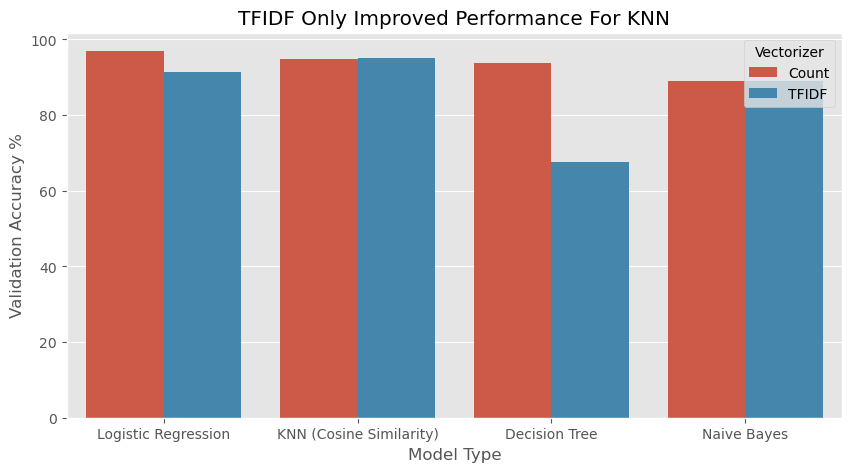

In [158]:
# Initialize the chart
plt.figure(figsize=(10,5))
# Create a bar plot from the validation accuracies in the results data frame
mod_perf_fig = sns.barplot(
    x='Model',
    y='Validation Accuracy',
    hue='Vectorizer',
    data=combined_results_df.sort_values('Validation Accuracy', ascending=False),
)
# Add a title and labels
plt.title('TFIDF Only Improved Performance For KNN')
plt.xlabel('Model Type')
plt.ylabel('Validation Accuracy %')
# Display the chart
plt.show()

As demonstrated by the above chart, TFIDF did not improve performance for any models with the exception of KNN, which was still outperformed by Logistic Regression trained using a Count Vectorizer. Given this, all models except the KNN model will be trained on content vectorized using the count vectorizer instead of the TFIDF vectorizer.

### Build Test Pipelines

Now that we have established some initial accuracy results with unoptimized models, these models should be tested and accuracies evaluated with some hyperparameter tuning. This grid search will utilize 5-fold cross validation and F1 scoring will be used as the primary method of evaluation as this represents a balance between precision and recall. The secondary scoring metric will be recall as for the purposes of fraud identification, it is better to have a false positive result than a false negative one.

In [163]:
# Set up temporary directory for pipeline cache
cachedir = mkdtemp()
# Initialize pipeline with count vectorizer, scaler and modelling stages
mod_pipeline = Pipeline([
        ('vectorize', cv_transf),
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())
    ],
    # Set the cache the the temp cache directory
    memory=cachedir
)

In [197]:
# Initialize the C values to be used to optimize the regularization strength of logistic regression
c_range = [10**i for i in range(-3, 4)]

# Initialize the parameter grid for use with the grid search for hyperparameter optimization
grid_search_param_grid = [
    # Set up hyperparameter optimization for Logistic Regression model
    {
        # Use standard and minmax scalers
        'scaler': [None, StandardScaler(), MinMaxScaler()],
        # Set model to be used as Logistic Regression
        'model': [LogisticRegression()],
        # Set C values for use with Logistic Regression
        'model__C': c_range, # Set regularization strength coefficients
        # Adjust penalties used with Logistic Regression
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        # Set solvers to be used with Logistic Regression
        'model__solver': ['lbfgs', 'liblinear'],

    },
    # Set up hyperparameter optimization for KNN model
    {
        # Use TFIDF and Count Vectorizers
        'vectorize': [cv_transf, tfidf_transf],
        # Use standard and minmax scalers
        'scaler': [StandardScaler(), MinMaxScaler()],
        # Set up model to be used as KNN
        'model': [KNeighborsClassifier()],
        # Set up range of neighbors to use with KNN
        'model__n_neighbors': range(5, 51, 5),
        # Set the different distances used to measure KNN distance
        'model__metric':['minkowski', 'cosine'],
    },
    # Set up hyperparameter optimization with Decision Tree classifier
    {
        # No scaler is necessary for Decision Tree classifiers to set to none
        'scaler': [None],
        # Set model to be used as decision tree classifier
        'model': [DecisionTreeClassifier()],
        # Set max model depth
        'model__max_depth': range(3, 21, 2),
    },
    # Set up hyperparameter optimization with Naive Bayes model
    {
        # No scaler necessary for Naive Bayes
        'scaler': [None],
        # Set model to be naive bayes
        'model': [BernoulliNB()],
        # Adjust the laplace smoothing parameter for Naive Bayes
        'model__alpha': range(0, 100, 10),
        
    }
]

# Initialize grid search to optimize hyperparameters
basic_model_cv = GridSearchCV(
    # Set pipeline to be run for the grid search
    estimator=mod_pipeline,
    # Set the number of cross validation folds to be used
    cv=5,
    # Initialize the parameter grid
    param_grid=grid_search_param_grid,
    # Set the model evaluation to use F1 scoring
    scoring=['f1', 'recall'],
    # Set the grid to output statements for each grid search run
    verbose=2,
    # Set refit value to recall indicating this as the deciding factor
    refit='recall',
)

In [198]:
# Fit the grid search
basic_model_cv.fit(X_remainder, y_remainder)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), 

[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.001, model__penalty=elasticnet, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression

[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scaler=None; total time=   2.8s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scaler=None; total time=   2.7s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scaler=None; total time=   2.8s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scaler=None; total time=   2.9s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.01, model__penalty=l2, model__solver=lbfgs, scal

[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=lbfgs, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=l1, model__so

[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=0.1, model__penalty=elasticnet, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END 

[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=lbfgs, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, scaler=None; total time=   2.8s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, scaler=None; total time=   2.9s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, scaler=None; total time=   2.8s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, scaler=None; total time=   2.9s
[CV] END model=LogisticRegression(), model__C=1, model__penalty=l2, model__solver=liblinear, scaler=None; t

[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, scaler=None; total time=   2.8s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, scaler=None; total time=  28.7s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, scaler=None; total time=  33.2s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, scaler=None; total time=  30.8s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, scaler=None; total time=  30.7s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=l1, model__solver=liblinear, 

[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, scaler=None; total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=10, model__penalty=elasticnet, model__solver=liblinear, scaler=MinMaxScaler(); total time=

[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=100, model__penalty=l2, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression()

[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, scaler=StandardScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=l1, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegress

[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=LogisticRegression(), model__C=1000, model__penalty=elasticnet, model__solver=liblinear, scaler=MinMaxScaler(); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=5, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=10, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=10, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=10, scaler=

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=15, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=15, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=15, scaler=

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=15, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=20, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=20, scaler=St

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=20, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=25, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=25, scaler=St

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=30, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=30, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=30, scaler=

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=35, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=35, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=35, scaler=

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=35, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=40, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=40, scaler=St

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=45, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=45, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=45, scaler=

[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=45, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=50, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=minkowski, model__n_neighbors=50, scaler=St

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=5, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=5, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=5, scaler=StandardScal

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=10, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=10, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=10, scaler=StandardS

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=15, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=15, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=15, scaler=StandardS

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=20, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=20, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=20, scaler=StandardS

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=25, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=25, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=25, scaler=StandardS

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=30, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=30, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=30, scaler=StandardS

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=35, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=35, scaler=MinMaxScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('count_vectorizer',
                                 CountVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=35, scaler=MinMaxScale

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=40, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=40, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=40, scaler=MinMaxSca

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=45, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=45, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=45, scaler=MinMaxSca

[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=50, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=50, scaler=StandardScaler(), vectorize=ColumnTransformer(remainder='passthrough',
                  transformers=[('tfidf_vectorizer',
                                 TfidfVectorizer(min_df=0.05,
                                                 tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                 'content')]); total time=   0.1s
[CV] END model=KNeighborsClassifier(), model__metric=cosine, model__n_neighbors=50, scaler=MinMaxSca

[CV] END model=DecisionTreeClassifier(), model__max_depth=15, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=15, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=15, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=15, scaler=None; total time=   3.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=17, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=17, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=17, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=17, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=17, scaler=None; total time=   3.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=19, scaler=None; total time=   2.8s
[CV] END model=DecisionTreeClassifier(), model__max_depth=19

GridSearchCV(cv=5,
             estimator=Pipeline(memory='/var/folders/t9/4whyp65x6cqg_kdhc89_f_080000gn/T/tmpnolx03yk',
                                steps=[('vectorize',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('count_vectorizer',
                                                                         CountVectorizer(min_df=0.05,
                                                                                         tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                                                         'content')])),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegres...
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf_vectorizer',
                                                                         TfidfVectorizer(min_df=0.05,
                                                                                         tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                                                         'content')])]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': range(3, 21, 2),
                          'scaler': [None]},
                         {'model': [BernoulliNB()],
                          'model__alpha': range(0, 100, 10),
                          'scaler': [None]}],
             refit='recall', scoring=['f1', 'recall'], verbose=2)

In [209]:
# Look at the best parameters for the grid search
basic_model_cv.best_estimator_

Pipeline(memory='/var/folders/t9/4whyp65x6cqg_kdhc89_f_080000gn/T/tmpnolx03yk',
         steps=[('vectorize',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('count_vectorizer',
                                                  CountVectorizer(min_df=0.05,
                                                                  tokenizer=<function custom_tokenizer at 0x7fefca973880>),
                                                  'content')])),
                ('scaler', None),
                ('model', LogisticRegression(C=10, solver='liblinear'))])

In [210]:
# Look at the best score for the grid search
basic_model_cv.best_score_

0.9505082141158392

As a result of the grid search it seems the best performing model was a Logistic Regression model with a regularization strength of 0.1, which receives a recall of 95% and an F1 score of 96.6%.

In [211]:
# Predict the values for the test set
y_test_pred = basic_model_cv.predict(X_test)

In [212]:
# Check accuracy score
accuracy_score(y_test, y_test_pred)

0.9725916968964128

This model results in a test accuracy score of 97% which seems fairly high. The confusion matrix for this model and the incorrectly categorized results will be examined further to see the shortcomings of the model.

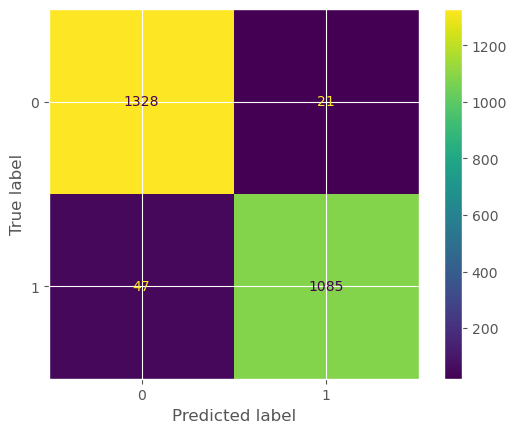

In [213]:
# Get confustion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
# Get display for confusion matrix
conf_disp = ConfusionMatrixDisplay(conf_matrix)
# Plot the confusion matrix
conf_disp.plot()
plt.show()

In [214]:
# Calculate the recall of the model
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]) * 100
# Calculate the precision of the model
precision = conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1]) * 100
# Print the precision and recall of the model
print(f'Recall: {recall}%')
print(f'Precision: {precision}%')

Recall: 95.84805653710248%
Precision: 98.10126582278481%


As demonstrated by the confusion matrix above, the recall of the model is 96% and precision is 98%. These values seem to be fairly high, which could be expected considering the high F1 score. Next, where the model is incorrect will be examined more closely.

In [215]:
# Get the X values where the predicted value does not equal the test value
wrong_pred = X_test[y_test_pred != y_test['fraud']]

In [216]:
# Get the Y values where the predicted value does not equal the test value
wrong_pred_y = y_test[y_test_pred != y_test['fraud']]

In [217]:
# Concatinate the data frames with wrong X and Y predictions
wrong_pred = pd.concat([wrong_pred, wrong_pred_y], axis=1)

In [218]:
# Check the false negative predictions
wrong_pred[wrong_pred['fraud'] == 1]

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
35,Hi for LESS struggle going on apparently they are the bound man to A complete corruption of history,1,0,1,18,1
149,Your registered name is included to show this message from Learn more width,1,0,1,13,1
189,mail it bin start target blank Sponsor virus ma non sai come i virus a virus A,1,0,15,17,1
208,HELLO I WILL WANT YOU TO KINDLY SUPPLY ME WITH SOME FROM YOUR STORE BUT BEFORE I COULD PLACE THE ORDER I WILL WANT YOU TO KINDLY ADVISE ME ON ANY OF LISTED PAYMENT MODE VISA OR CARD YOU CAN ALSO GET BACK TO ME WITH THE SHIPPING COST VIA DAYS DOWN TO AND DO NOT FORGET TO INCLUDE YOUR SO THAT I COULD PICK OUT MY CHOICE FOR YOU TO BE ABLE TO QUOTE ME TO READ FROM YOU MY local movie times and on Yahoo,0,0,6,87,1
345,committee representative whose name below We wait in anticipation of your operation Yours faithfully Ben DEPARTMENT OF AND OF SOUTH See their hear their laughter with Messenger messenger za,1,0,0,29,1
371,net mac net net UM ford mi net yahoo zoid UM UM excite net trinity health UM us net UM net UM net net UM UM UM patel UM yahoo net saraband UM yahoo yahoo UM UM UM UM UM rob net net net net net,0,0,5,46,1
447,to hear from you Thanks Yours Faithfully,0,0,0,7,1
479,con Free in In se ti gratis al non di it,1,0,5,11,1
506,is this Tue yahoo ca wrote FROM PHON,0,0,11,8,1
600,Parker Home Try On New available to try at home We just added of new glasses to our Home Try On assortment Find out which you should try with our super easy quiz Get,0,0,3,34,1


Looking at the messages the model identified as false negatives seem to often relate to several forms of fraud. One such example is when the sender pretends to be starting a business venture with a need for initial capital, a legal institution or some unusual business. The others seem to be short with a link potentially leading to a fraudulent website. These were likely missed by the model due to a lack of words within them relating to fraudulent emails thus preventing the model from identifying them. With further examples and training, it is possible would be able to correctly identify these types of emails.

In [220]:
# Check the false positive predictions
wrong_pred[wrong_pred['fraud'] == 0]

,content,unsecure_link_count,secure_link_count,numbers_count,word_count,fraud
89,Weekly Newsletter Reseller Corp Net One World Hosting Superb More Live tech help now Choice million open News Top Senior editor and Dear Your if its anything like mine works like a very large boat It slowly it turns slowly and sometimes it Take rogue wireless for example For many now some mischievous have been hacking into major and off for neighborhood wireless Only now later are doing something about it And what about Could they break into your service provider Probably Thankfully you can ...,0,0,27,371,0
151,that you offer the possibility of you the slightly offer The one thing we have to be careful of is the criticism that we are spending billion for We have but that the criticism,0,0,3,34,0
266,The Public Library Board the library on city of does not a bank loan of up to million and property tax receipts are,0,0,3,23,0
363,Dear Our indicate that you have either or the Fall Commuter Application If you no longer wish to have a commuter meal plan for the spring semester you do not need to do anything If you are an commuter student and wish to have a Spring meal plan you will need to complete the Spring Commuter Application and select a meal plan for the Spring Term If you are an athlete that a meal plan scholarship Please note that the meal plan is covered under that scholarship If you select a meal plan other th...,0,0,9,163,0
434,for Palm OS and Pocket beta for beta for and Mac OS beta for Mac OS and enter beta for Palm OS and Pocket beta the following new to A System Information accessible from either the document list view or while a document through the menu The the user name owner name and the associated user ID of the device For Palm OS the also the free and total amount of dynamic and storage memory Support for password The password protection is into the document during conversion and can not be nor removed fr...,1,0,98,645,0
535,May Band service RELEASE IN PART Dear dear,0,0,6,8,0
574,It would appear that Yahoo the of western to helping restrict the of people in other for the sake of improving their profit Yahoo the Public Pledge on Self discipline for China Industry more here china essentially a promise to help police for the State From this article in The Times technology story The version of the popular Yahoo portal becoming an policeman for communist government if it a promise to voluntarily investigate potentially subversive content a human group If it the pledge Yah...,4,0,5,115,0
618,be careful when this one Also that really cute thing that do of leaving their panties on one leg while making love Dare I ask what a girl is Yahoo Sponsor Free Join Now us click yahoo To from this group send an to Your use of Yahoo is subject to yahoo,2,0,4,52,0
694,I this up for testing before I commit to a of as an relay It is more work but it in mail delivery during the early of testing On the Exchange server mail Create a new private address for the mailbox you want to protect Remove the old address Create a custom recipient with the old address Create another custom recipient pointing at a local user on the box Set the first custom recipient to forward all mail to the second custom recipient must forward to another address in the Exchange directory...,1,1,0,225,0
803,Content Disposition Dear member If you can see this you have been to the list as an user To switch to plain text mail go to You are as You up to receive on exclusive and at Wed love to continue to bring you this news however if you wish to remove yourself from this list go to Content Disposition You are as up to receive on exclusive and at Wed love to continue to bring you this news however if you wish to remove yourself from this list Click here Please do not reply to this message If you ha...,2,0,5,118,0


The messages the model falsely identified as fraud seem to largely relate to banking, security, or a government institution. This makes sense since many fraud emails tend to falsely identify themselves as coming from one of these institutions or organizations. It may be difficult to prevent the model from making these types of identifications but it is possible a model like XG-Boost could be used to prevent errors such as this.

## Conclusion